In [1]:
from typing import Tuple

import os

import json

import pandas as pd

import seaborn as sns

In [11]:
def get_products(df: pd.DataFrame) -> pd.DataFrame:

    # Filter out empty areas
    filter_df = df[df["areas"].astype(str) != "[]"].copy()

    # Explode multiple areas per row
    filter_df = filter_df.explode("areas")

    products_df = []

    # If no hits are found
    if not len(filter_df):
        record_id = df["record_id"].unique()[0]
        products_df.append(
            pd.Series({
                "record_id": record_id,
                "sample_id": record_id.split("_")[-1],
                "seq": None,
                "features": None,
                "name": None,
                "description": None,
                "dbxrefs": None,
                "annotations": None,
                "letter_annotations": None,
                "areas": None,
                "gc_content": None,
                "modules": None
            }).to_frame().T
        )

    else:
        for _, row in filter_df.iterrows():
            areas_df = pd.Series(row["areas"]).to_frame().T
            areas_df = areas_df.explode("products")
            areas_df["record_id"] = row["record_id"]
            areas_df["name"] = row["name"]

            products_df.append(areas_df)

    products_df = pd.concat(products_df)

    products_df["sample_id"] = products_df["record_id"]\
        .str.split("_").str[-1]

    return products_df


def get_genes(df: pd.DataFrame) -> pd.DataFrame:
    # Path: records/modules/antismash.detection.genefunctions/tools/best_hits

    # Get modules
    genes_df = pd.concat([
        pd.DataFrame(row).T
        for row in df["modules"]
    ])

    # Placeholder in case no hits are found
    record_id = df["record_id"].unique()[0]
    empty_genes_df = pd.Series({
        "hit_id": None,
        "query_start": None,
        "query_end": None,
        "evalue": None,
        "bitscore": None,
        "sample_id": record_id.split("_")[-1],
        "gene_id": None
    }).to_frame().T

    # If module is not found
    if not "antismash.detection.genefunctions" in genes_df.index:
        genes_df = empty_genes_df.copy()
    else:
        # Filter by antismash.detection.genefunctions
        genes_df = genes_df.loc["antismash.detection.genefunctions"]

        # Get predictions by tool
        genes_df = pd.concat([
            pd.DataFrame(row)
            for row in genes_df["tools"]
        ])

        # Filter by smCOG
        genes_df = genes_df[genes_df["tool"] == "smcogs"]

        if not len(genes_df["best_hits"]):
            genes_df = empty_genes_df.copy()

        else:
            # Get best hits predicted by smCOG
            genes_df = pd.concat([
                pd.DataFrame(row).T
                for row in genes_df["best_hits"]
            ])
            genes_df = genes_df\
                .reset_index(drop=False)\
                .rename(columns={"index": "sample_gene"})

            # Add sample and gene IDs
            genes_df[["sample_id", "gene_id"]] = genes_df["sample_gene"]\
                .str.split("_", expand=True)
            genes_df = genes_df.drop("sample_gene", axis=1)

    return genes_df


def get_hits(filepath: str) -> Tuple[pd.DataFrame, pd.DataFrame]:

    with open(filepath, mode="r") as handle:
        content = json.load(handle)

    results_df = pd.DataFrame(content["records"])
    results_df = results_df.rename(columns={"id": "record_id"})

    # ------------------------------------------------------------------------ #
    # Get information on products
    products_df = get_products(results_df)

    # ------------------------------------------------------------------------ #
    # Get information on genes
    genes_df = get_genes(results_df)

    # ------------------------------------------------------------------------ #
    # Merge both genes and products

    # Add sample and MAG information
    products_df["sample_name"] = os.path.basename(
        os.path.dirname(os.path.dirname(filepath))
    )
    products_df["mag_name"] = os.path.basename(os.path.dirname(filepath))

    genes_df = pd.merge(
        left=products_df,
        right=genes_df,
        how="left",
        on="sample_id"
    )

    return products_df, genes_df


def get_heat_df(
    df: pd.DataFrame,
    target_col: str
) -> pd.DataFrame:

    heat_df = df\
        .groupby(["sample_name", target_col], as_index=False)\
        .size()

    heat_df = heat_df.pivot(
        index="sample_name",
        columns=target_col,
        values="size"
    )
    heat_df = heat_df.fillna(0.0)

    return heat_df


def get_annotations(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:

    # Color by sample type
    df["sample_type"] = df.index.str.contains("GLDS").astype(int)
    sample_colors = df["sample_type"].map({
        0: "orange",
        1: "lightblue"
    })

    # Color by control column
    df["control"] = df.index.str.contains("_5501_|_5503_").astype(int)
    control_colors = df["control"].map({
        0: "gray",
        1: "salmon"
    })

    # Color by treatment
    df["treatment"] = df.index.str.split("_").str[-2]
    df["treatment"] = df["treatment"].map({
        "NORM": 0,
        "PMA": 1
    })
    treat_colors = df["treatment"].map({
        0: "gray",
        1: "lightgreen"
    })

    row_colors = pd.concat(
        [control_colors, sample_colors, treat_colors],
        axis=1
    )

    return df, row_colors


def get_taxonomy(
    df: pd.DataFrame,
    taxonomy_path: str
) -> pd.DataFrame:

    taxonomy_df = pd.read_csv(
        taxonomy_path,
        sep="\t"
    )

    df["Assembly"] = df["sample_name"]\
        .str.replace("GLDS-69_GMetagenomics_", "")
    df["Assembly"] = df["Assembly"] + "-" + df["mag_name"]

    df = pd.merge(
        left=df,
        right=taxonomy_df[["Assembly", "species"]],
        on="Assembly",
        how="left"
    )

    # Add NCBI species from sample name (Assembly column)
    df["species"] = df["species"]\
        .fillna(value=df["Assembly"])\
        .str.split("-").str[0]\
        .str.replace("_", " ")\
        .str.capitalize()

    # Add sample type to species
    df["sample_type"] = df["sample_name"]\
        .str.contains("GLDS").astype(int)
    df["sample_type"] = df["sample_type"].replace({
        0: "ncbi",
        1: "genelab"
    })
    df["species"] = \
        df["species"] + " (" + df["sample_type"] + ")"

    return df

In [3]:
DATA_DIR = "../data/genelab/OSD-69/"

TAXONOMY_PATH = os.path.join(
    DATA_DIR,
    "genelab/raw/",
    "GLDS-69_GMetagenomics_MAGs-overview.tsv"
)

In [4]:
sample_type_list = ["genelab"]

results_df_prods = []
results_df_genes = []

for sample_type in sample_type_list:

    sample_type_dir = os.path.join(
        DATA_DIR,
        sample_type,
        "antismash"
    )

    for sample_dir in os.listdir(sample_type_dir):
        sample_dir = os.path.join(sample_type_dir, sample_dir)

        if os.path.isdir(sample_dir):
            for mag_name in os.listdir(sample_dir):
                mag_folder = os.path.join(sample_dir, mag_name)

                results_path = os.path.join(
                    mag_folder,
                    f"{mag_name}.json"
                )

                if os.path.exists(results_path):
                    products_df, genes_df = get_hits(results_path)
                    results_df_prods.append(products_df)
                    results_df_genes.append(genes_df)
                else:
                    print("[ERROR] File not found:", results_path)

results_df_prods = pd.concat(results_df_prods)
results_df_genes = pd.concat(results_df_genes)

results_df_genes.head()

[ERROR] File not found: ../data/genelab/OSD-69/genelab/antismash/GLDS-69_GMetagenomics_5629_IF1SW-M_F1_L1_NORM_FLT/MAG-3/MAG-3.json


,start,end,products,protoclusters,candidates,subregions,record_id,name,sample_id,sample_name,...,gene_id,seq,features,description,dbxrefs,annotations,letter_annotations,areas,gc_content,modules
0,44440,88027,arylpolyene,"{'0': {'category': 'PKS', 'start': 44440, 'end...","[{'start': 44440, 'end': 88027, 'kind': 'singl...",[],c_5633_IF5SW-M_F1_L5_NORM_FLT_3149,c_5633_IF5SW-M_F1_L5_NORM_FLT_3149,3149,GLDS-69_GMetagenomics_5633_IF5SW-M_F1_L5_NORM_FLT,...,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44440,88027,arylpolyene,"{'0': {'category': 'PKS', 'start': 44440, 'end...","[{'start': 44440, 'end': 88027, 'kind': 'singl...",[],c_5633_IF5SW-M_F1_L5_NORM_FLT_3149,c_5633_IF5SW-M_F1_L5_NORM_FLT_3149,3149,GLDS-69_GMetagenomics_5633_IF5SW-M_F1_L5_NORM_FLT,...,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44440,88027,arylpolyene,"{'0': {'category': 'PKS', 'start': 44440, 'end...","[{'start': 44440, 'end': 88027, 'kind': 'singl...",[],c_5633_IF5SW-M_F1_L5_NORM_FLT_3149,c_5633_IF5SW-M_F1_L5_NORM_FLT_3149,3149,GLDS-69_GMetagenomics_5633_IF5SW-M_F1_L5_NORM_FLT,...,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44440,88027,arylpolyene,"{'0': {'category': 'PKS', 'start': 44440, 'end...","[{'start': 44440, 'end': 88027, 'kind': 'singl...",[],c_5633_IF5SW-M_F1_L5_NORM_FLT_3149,c_5633_IF5SW-M_F1_L5_NORM_FLT_3149,3149,GLDS-69_GMetagenomics_5633_IF5SW-M_F1_L5_NORM_FLT,...,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,44440,88027,arylpolyene,"{'0': {'category': 'PKS', 'start': 44440, 'end...","[{'start': 44440, 'end': 88027, 'kind': 'singl...",[],c_5633_IF5SW-M_F1_L5_NORM_FLT_3149,c_5633_IF5SW-M_F1_L5_NORM_FLT_3149,3149,GLDS-69_GMetagenomics_5633_IF5SW-M_F1_L5_NORM_FLT,...,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Products

### Samples heatmap (GeneLab)

In [5]:
heat_df_prods = get_heat_df(df=results_df_prods, target_col="products")
heat_df_prods, row_colors_prods = get_annotations(heat_df_prods)
heat_df_prods.head()

products,LAP,NAPAA,NI-siderophore,NRP-metallophore,NRPS,NRPS-like,PKS-like,RRE-containing,RiPP-like,T1PKS,...,phosphonate-like,proteusin,ranthipeptide,redox-cofactor,terpene,thiopeptide,transAT-PKS,sample_type,control,treatment
sample_name,,,,,,,,,,,,,,,,,,,,,
GLDS-69_GMetagenomics_5492_IG2SW-M_F1_L2_NORM_GC,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,...,1.0,0.0,0.0,1.0,5.0,0.0,0.0,1,0,0
GLDS-69_GMetagenomics_5501_IG2SW-P-M_F1_L2_PMA_GC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1
GLDS-69_GMetagenomics_5630_IF2SW-M_F1_L2_NORM_FLT,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0
GLDS-69_GMetagenomics_5631_IF3SW-P-M_F1_L3_PMA_FLT,0.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.0,2.0,6.0,0.0,0.0,1,0,1
GLDS-69_GMetagenomics_5633_IF5SW-M_F1_L5_NORM_FLT,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1,0,0


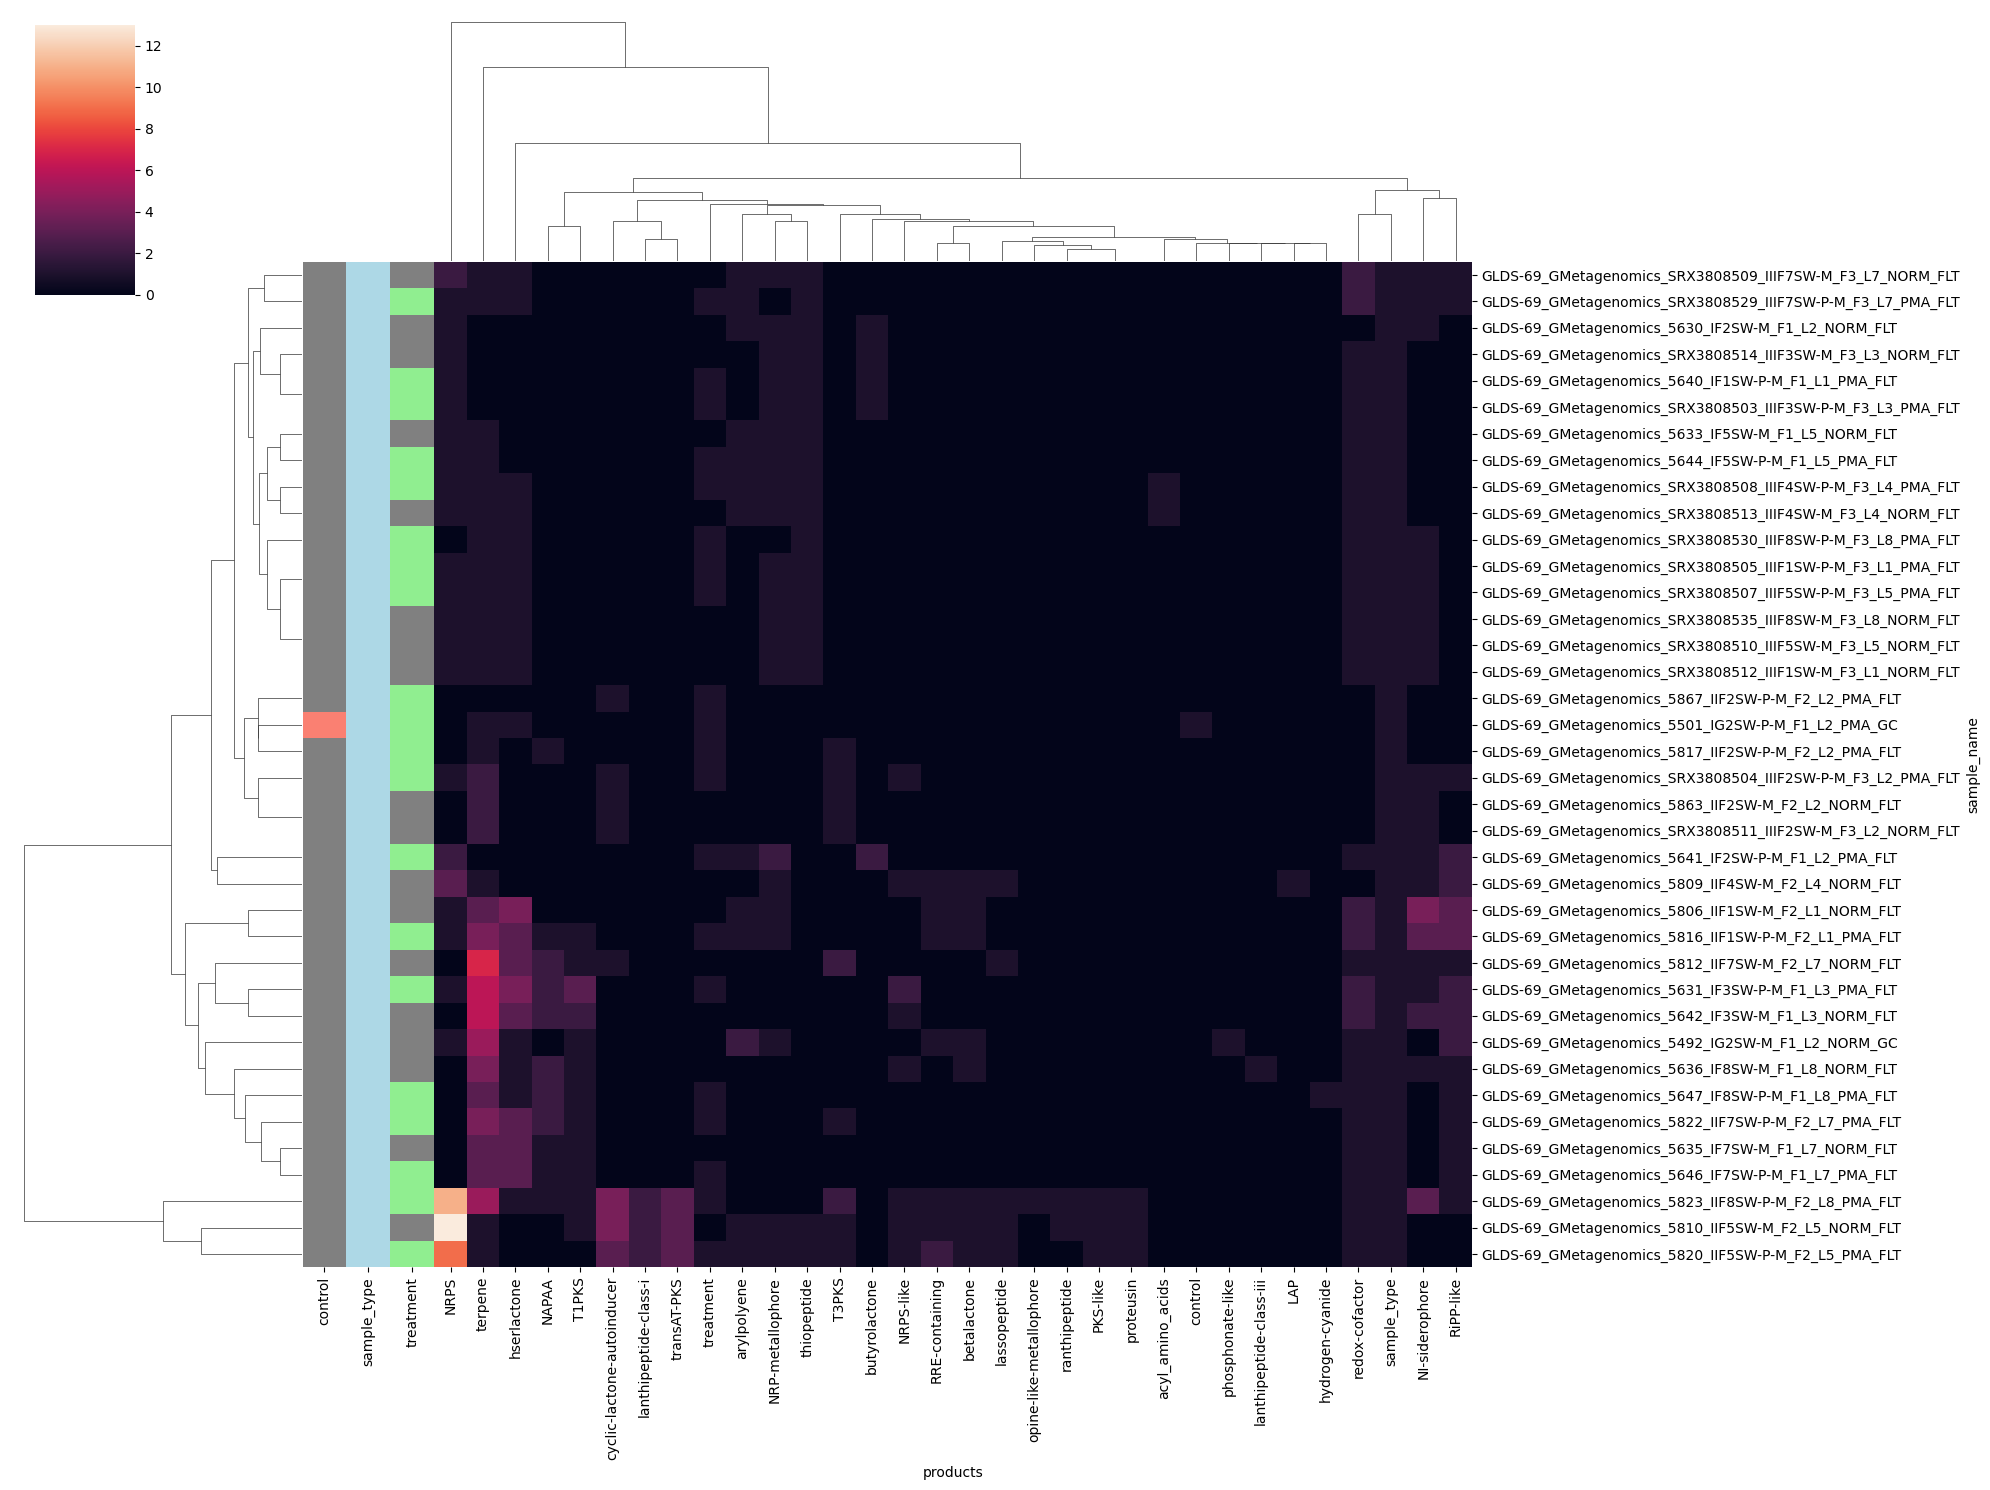

In [14]:
fig = sns.clustermap(
    data=heat_df_prods,
    row_colors=row_colors_prods,
    figsize=(20, 15)
)
fig.savefig(
    fname="../figures/antismash-heatmap-absolute-genelab.svg",
    dpi=500
)

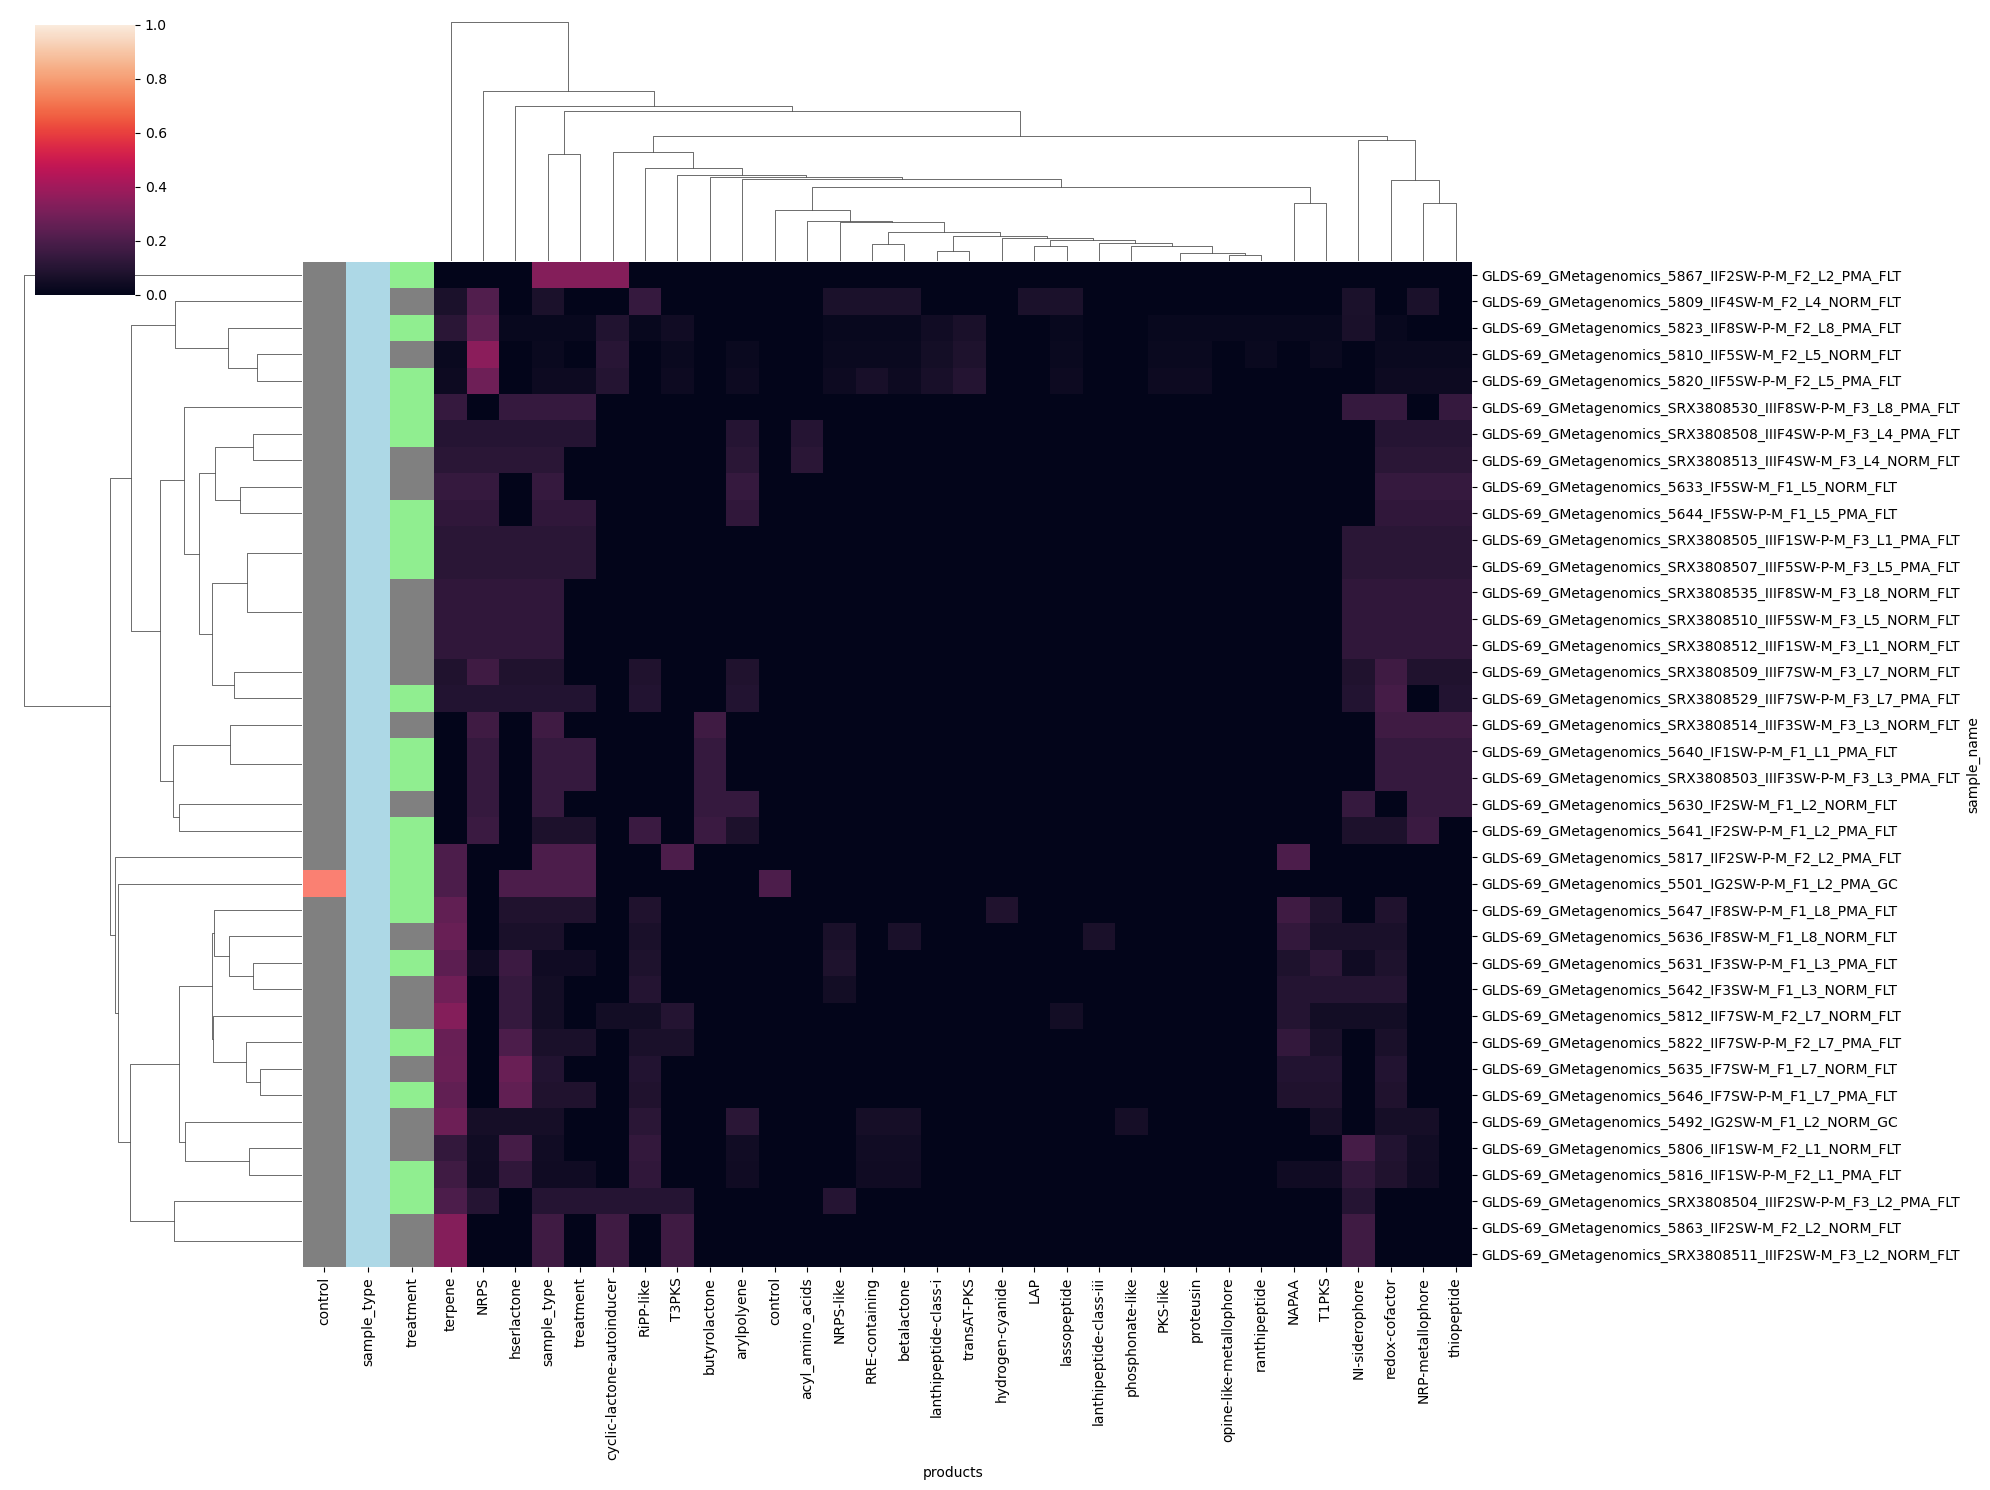

In [15]:
# See https://stackoverflow.com/a/18594595
heat_df_prods_row_norm_genelab = heat_df_prods.div(
    heat_df_prods.sum(axis=1),
    axis=0
)

fig = sns.clustermap(
    data=heat_df_prods_row_norm_genelab,
    row_colors=row_colors_prods,
    figsize=(20, 15),
    vmin=0.0,
    vmax=1.0
)
fig.savefig(
    fname="../figures/antismash-heatmap-rownorm-genelab.svg",
    dpi=500
)

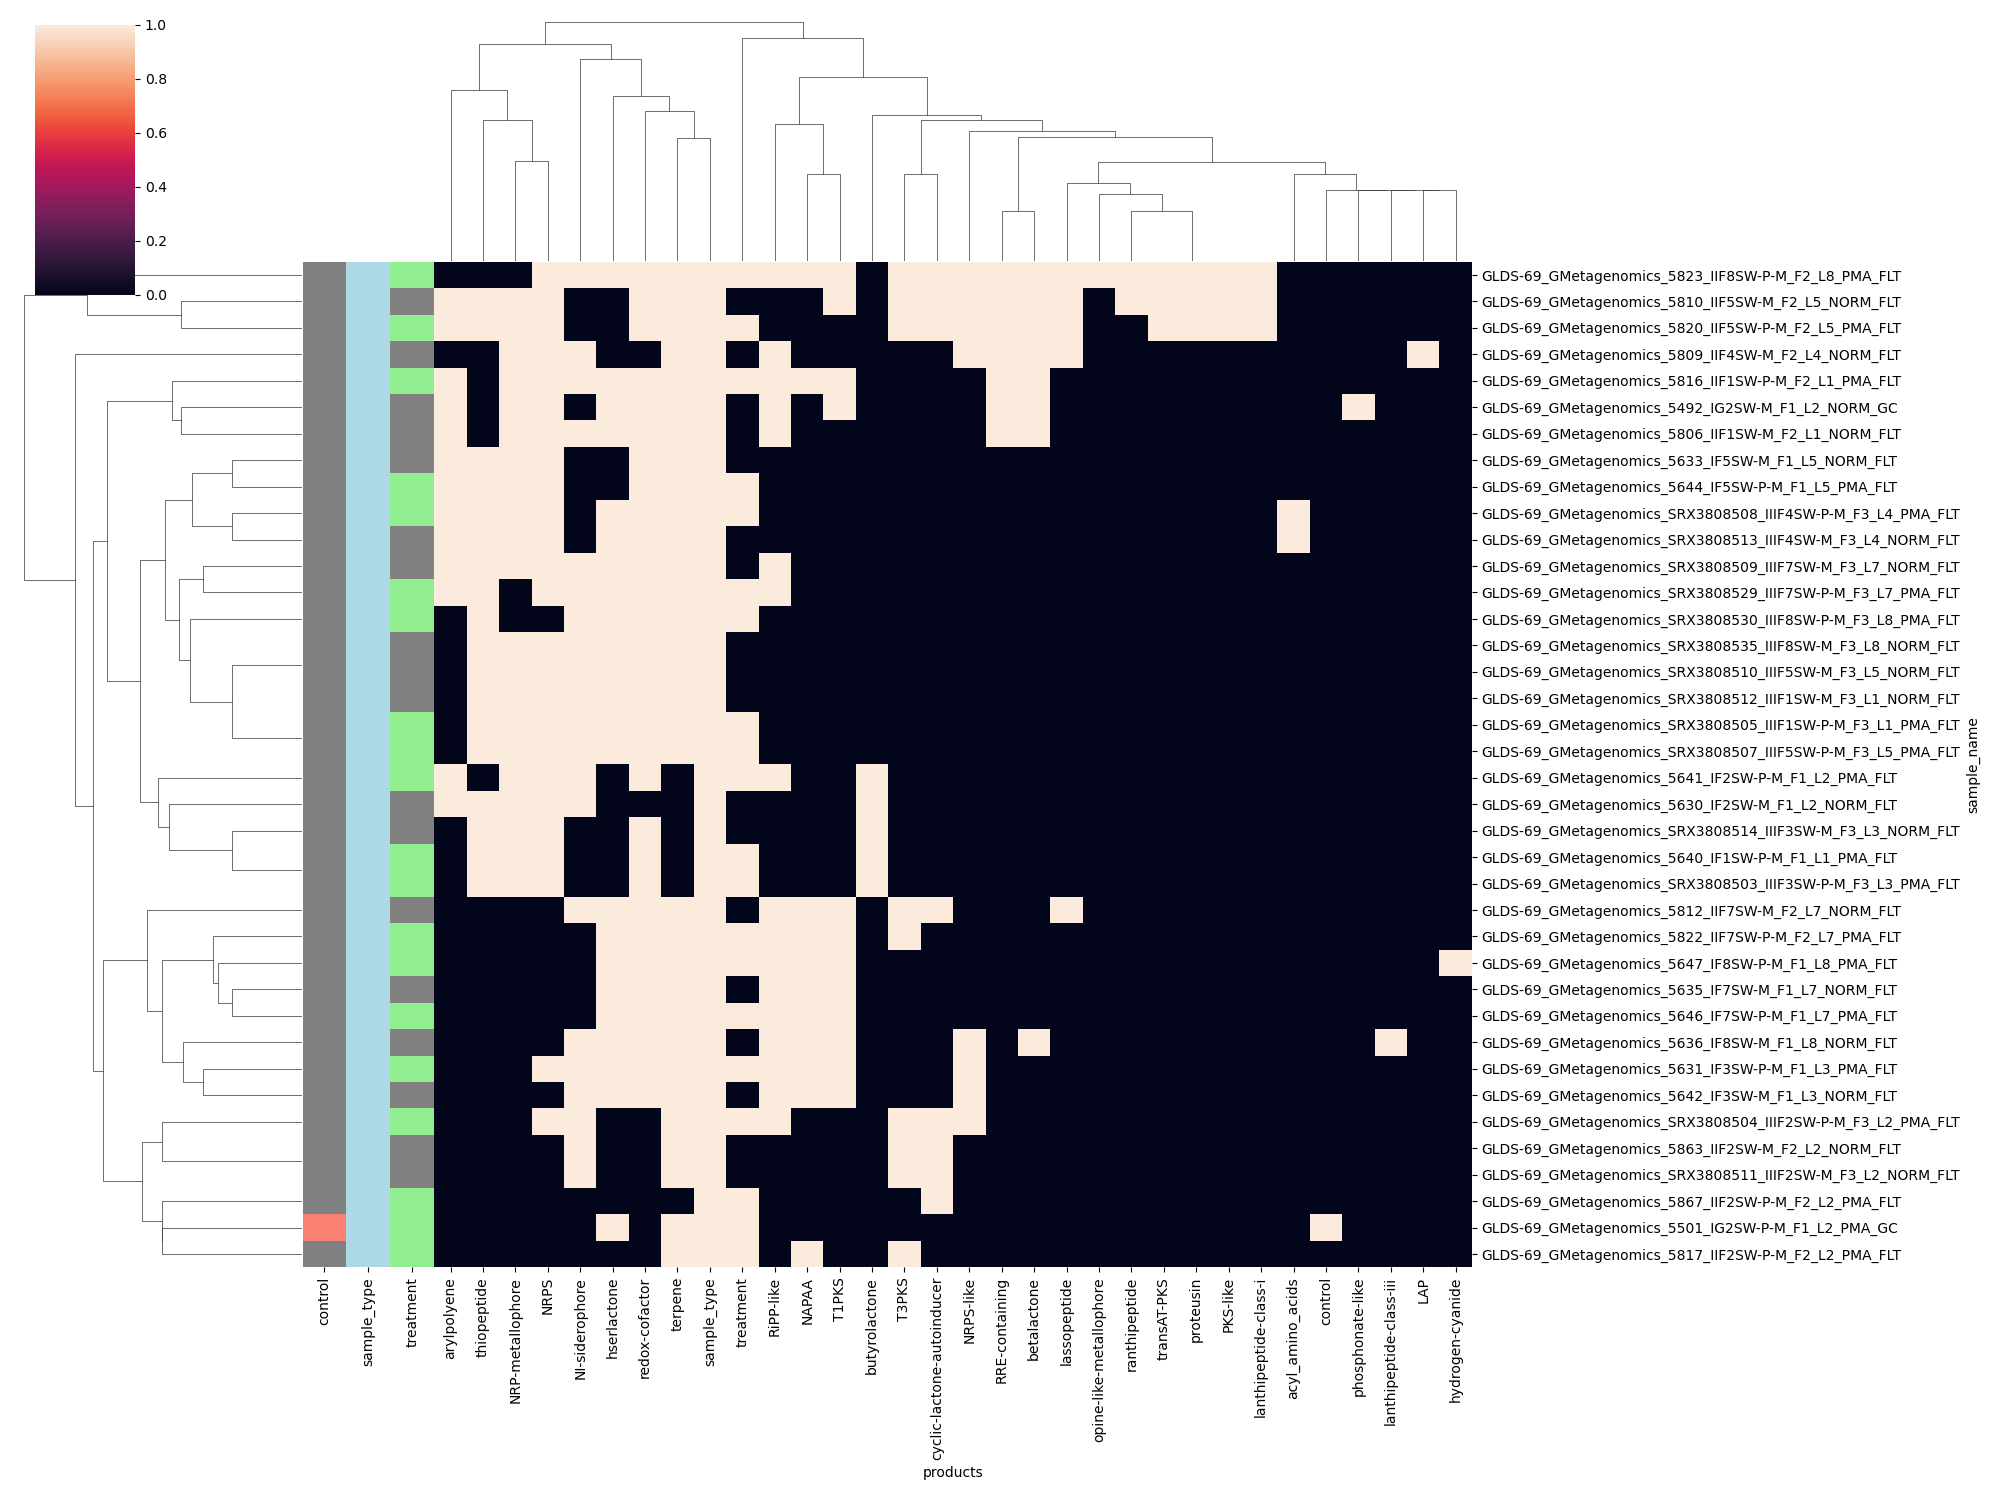

In [16]:
fig = sns.clustermap(
    data=heat_df_prods.astype(bool).astype(int),
    row_colors=row_colors_prods,
    figsize=(20, 15)
)
fig.savefig(
    fname="../figures/antismash-heatmap-binary-genelab.svg",
    dpi=500
)

### Species heatmap (GeneLab + NCBI)

In [12]:
# TODO: check whether to add mag_name to the grouping columns
species_df = get_taxonomy(
    df=results_df_prods,
    taxonomy_path=TAXONOMY_PATH
)

species_df = species_df\
    .groupby(["species", "products"], as_index=False)\
    .size()

species_df = species_df.pivot(
    index="species",
    columns="products",
    values="size"
)
species_df = species_df.fillna(0.0)

# Color by sample type
species_df["sample_type"] = species_df.index.str.contains("genelab").astype(int)
sample_colors = species_df["sample_type"].map({
    0: "orange",
    1: "lightblue"
})

species_df = species_df.drop(["sample_type"], axis=1)

species_df.head()

products,LAP,NAPAA,NI-siderophore,NRP-metallophore,NRPS,NRPS-like,PKS-like,RRE-containing,RiPP-like,T1PKS,...,lanthipeptide-class-iii,lassopeptide,opine-like-metallophore,phosphonate-like,proteusin,ranthipeptide,redox-cofactor,terpene,thiopeptide,transAT-PKS
species,,,,,,,,,,,,,,,,,,,,,
5492 ig2sw (genelab),0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0
5631 if3sw (genelab),0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
5636 if8sw (genelab),0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
5642 if3sw (genelab),0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
Acinetobacter pittii (genelab),0.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


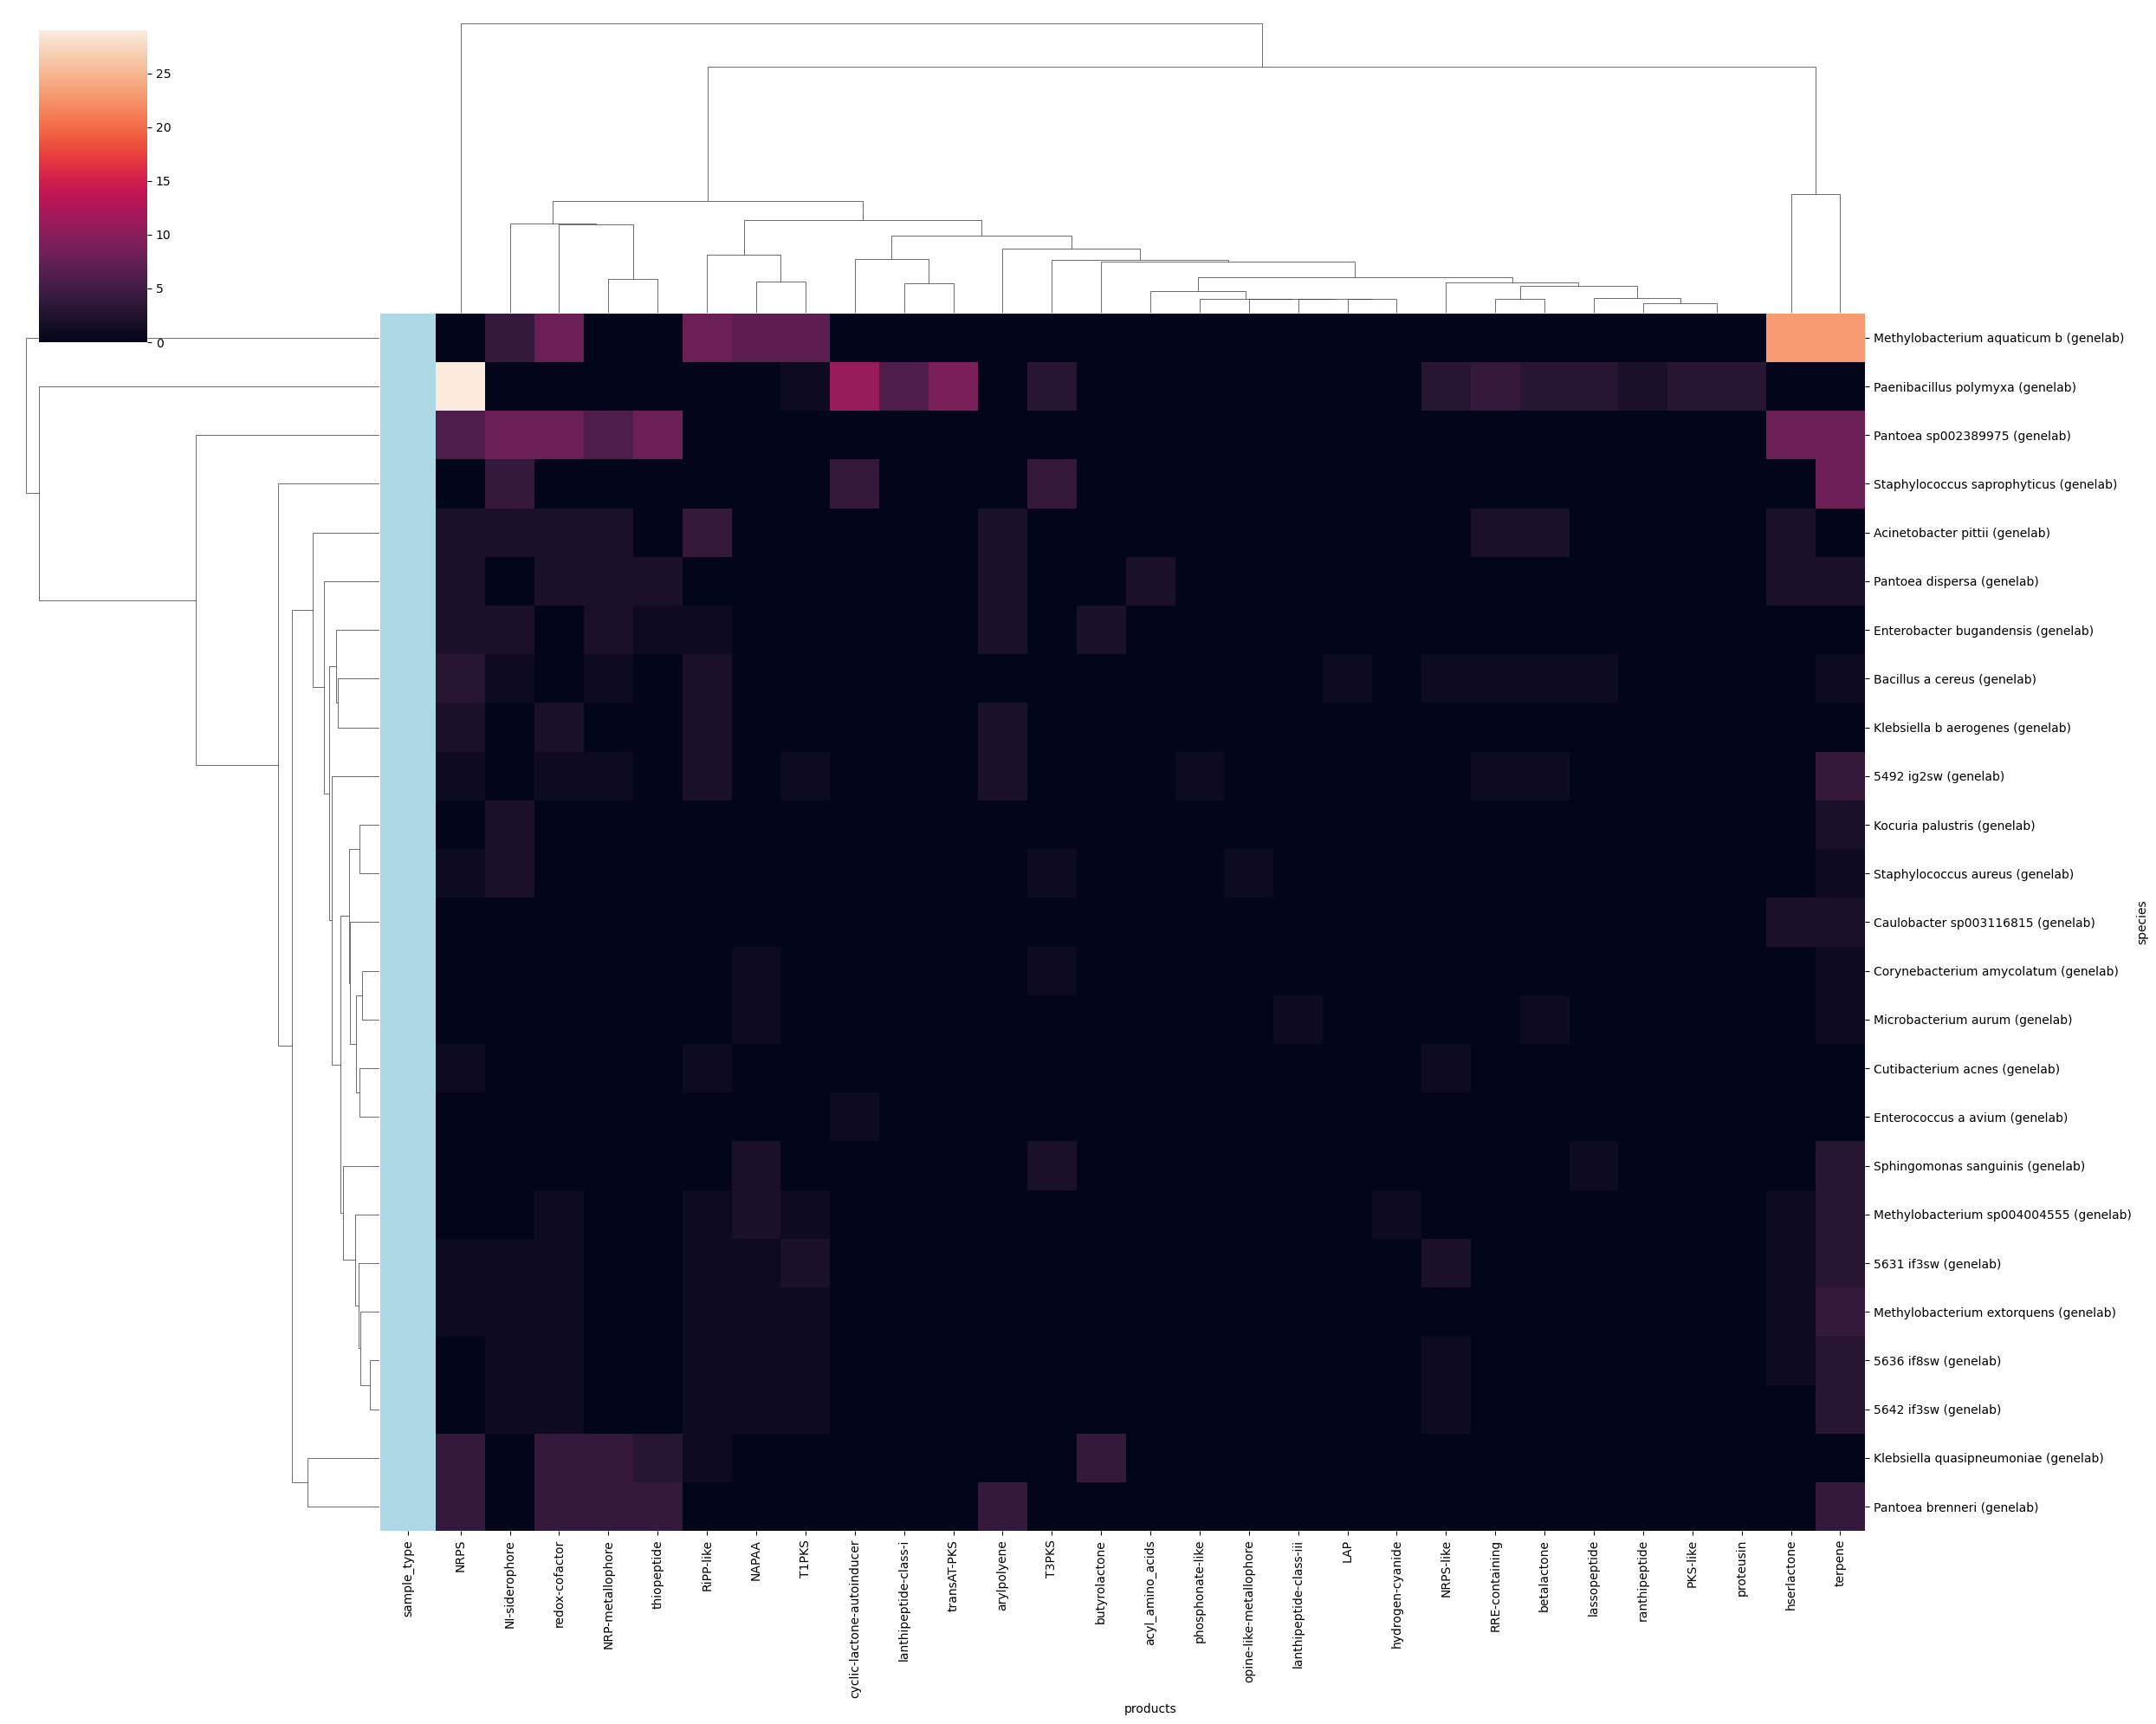

In [13]:
fig = sns.clustermap(
    data=species_df,
    row_colors=sample_colors,
    figsize=(25, 20)
)
fig.savefig(
    fname="../figures/antismash-heatmap-absolute-species.svg",
    dpi=500
)

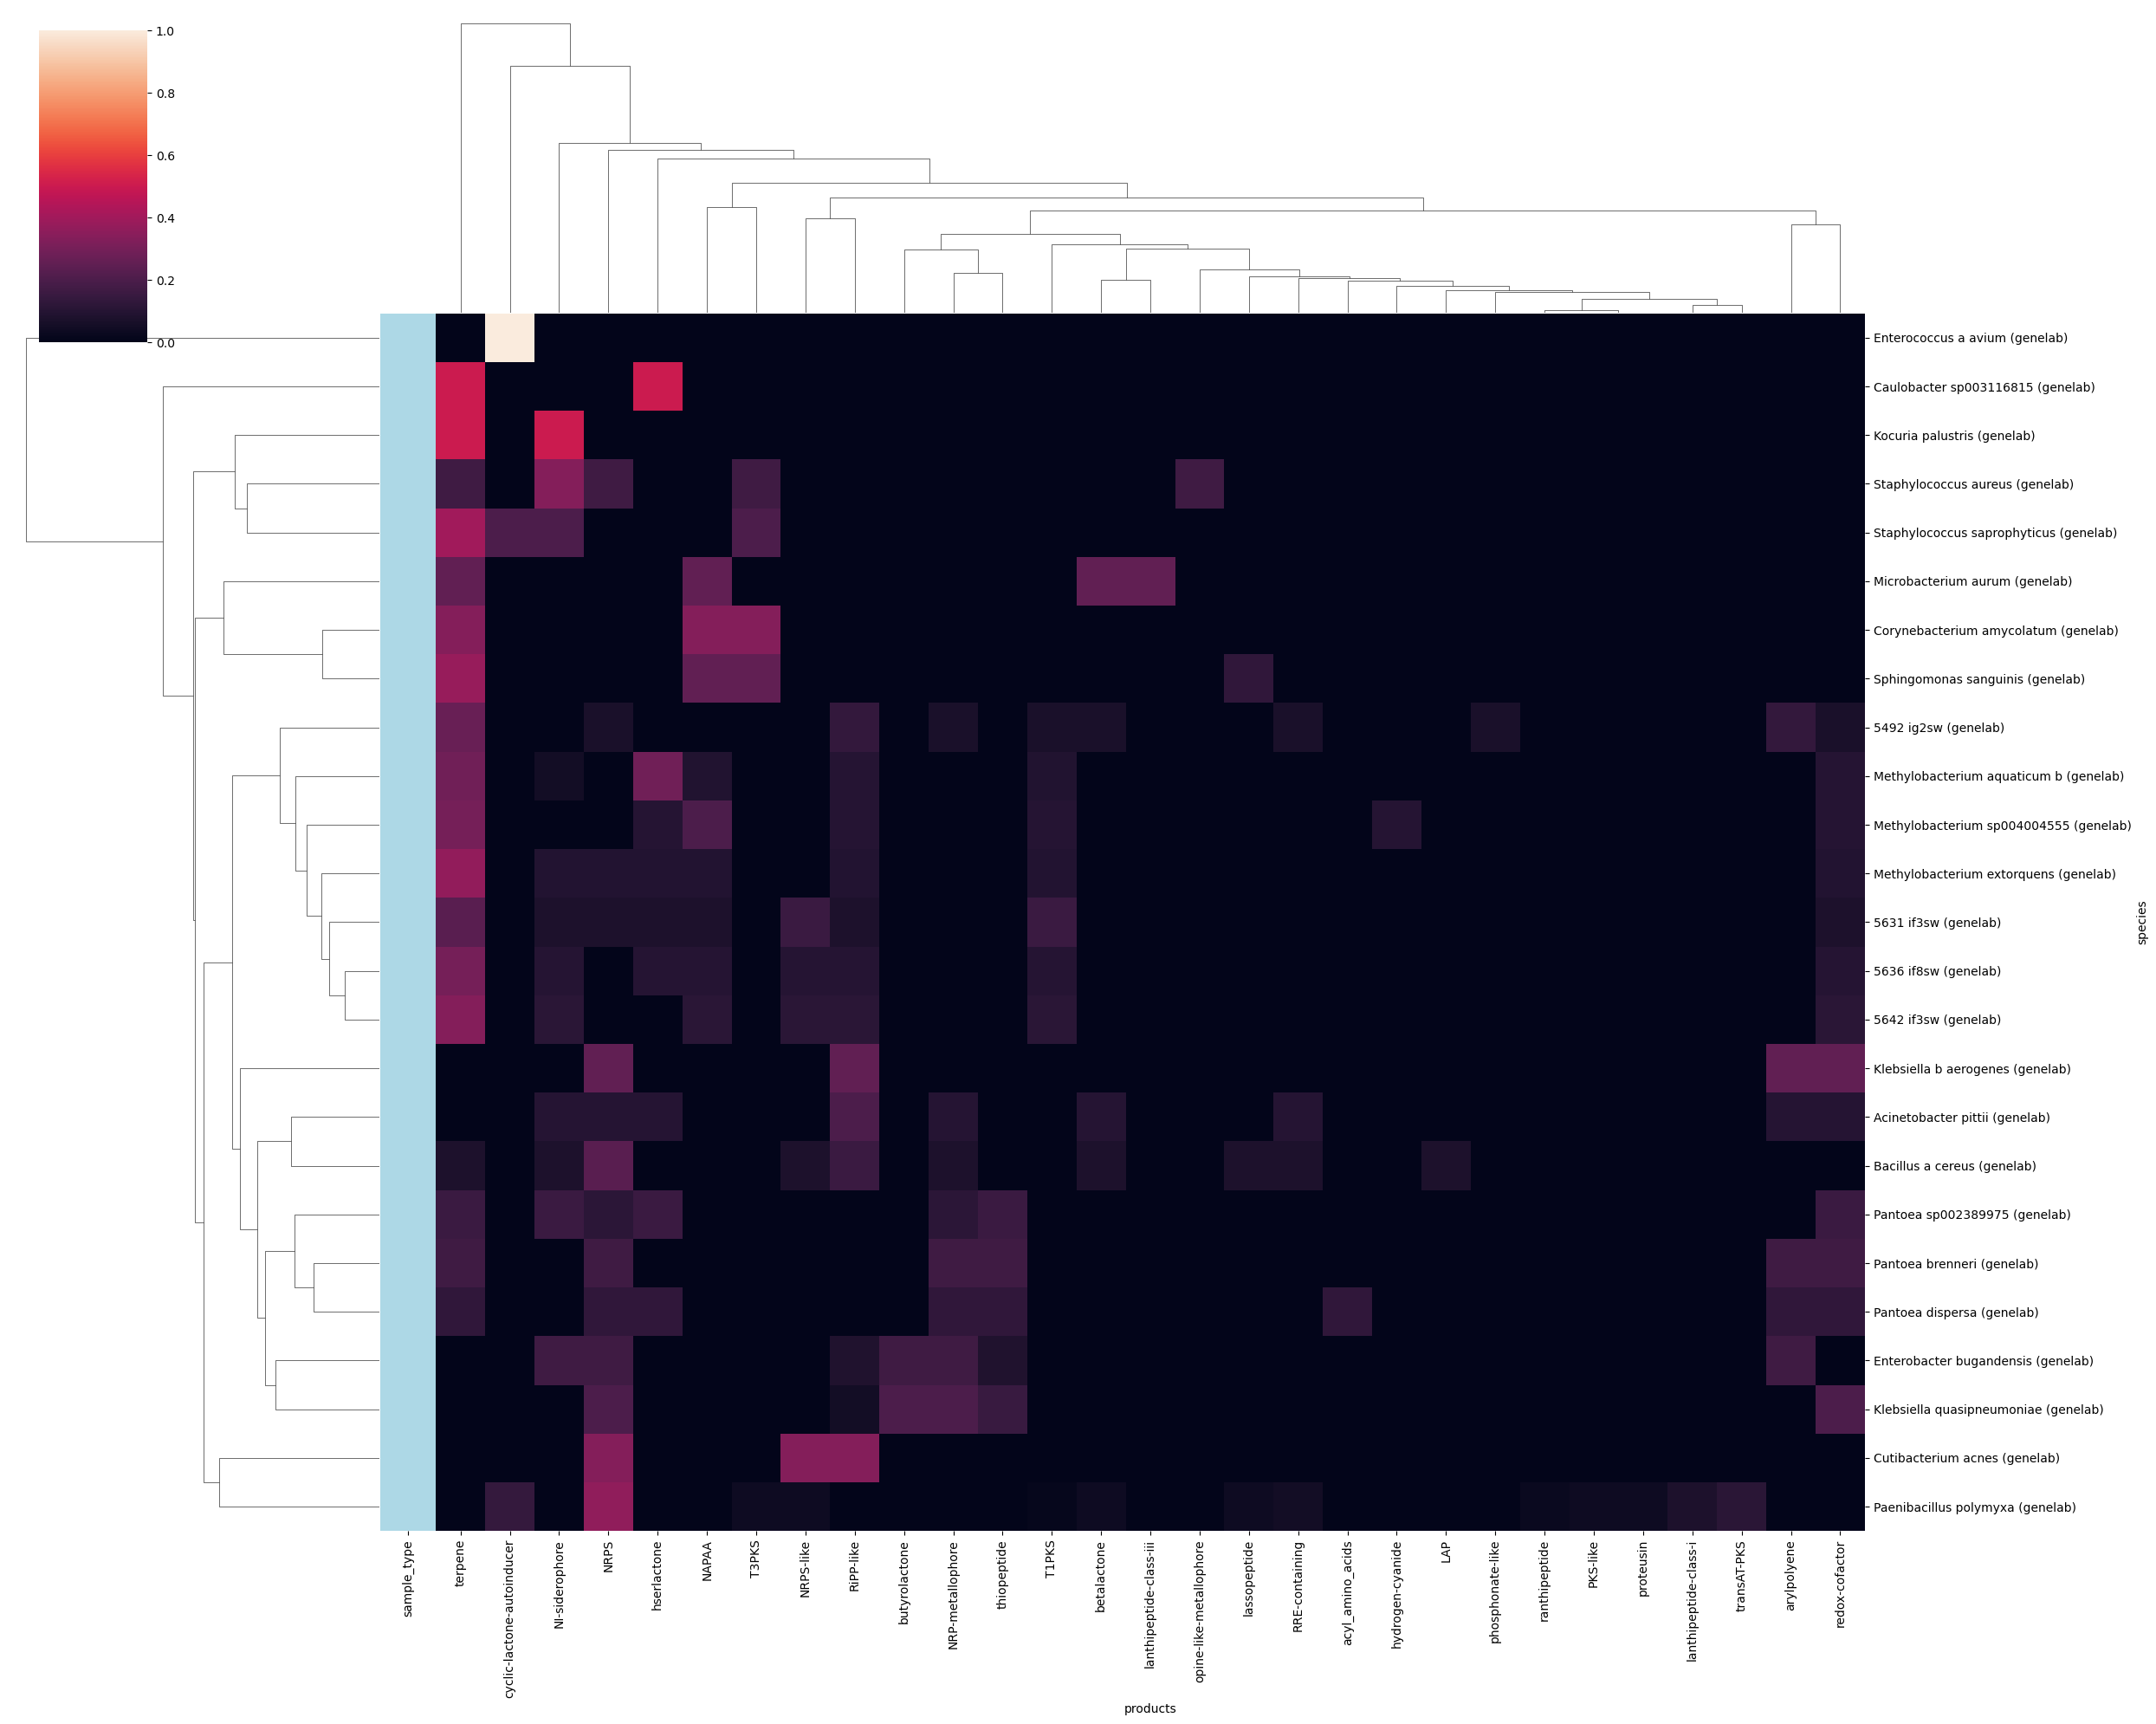

In [14]:
# See https://stackoverflow.com/a/18594595
species_df_row_norm = species_df.div(species_df.sum(axis=1), axis=0)

fig = sns.clustermap(
    data=species_df_row_norm,
    row_colors=sample_colors,
    figsize=(25, 20),
    vmin=0.0,
    vmax=1.0
)
fig.savefig(
    fname="../figures/antismash-heatmap-rownorm-species.svg",
    dpi=500
)

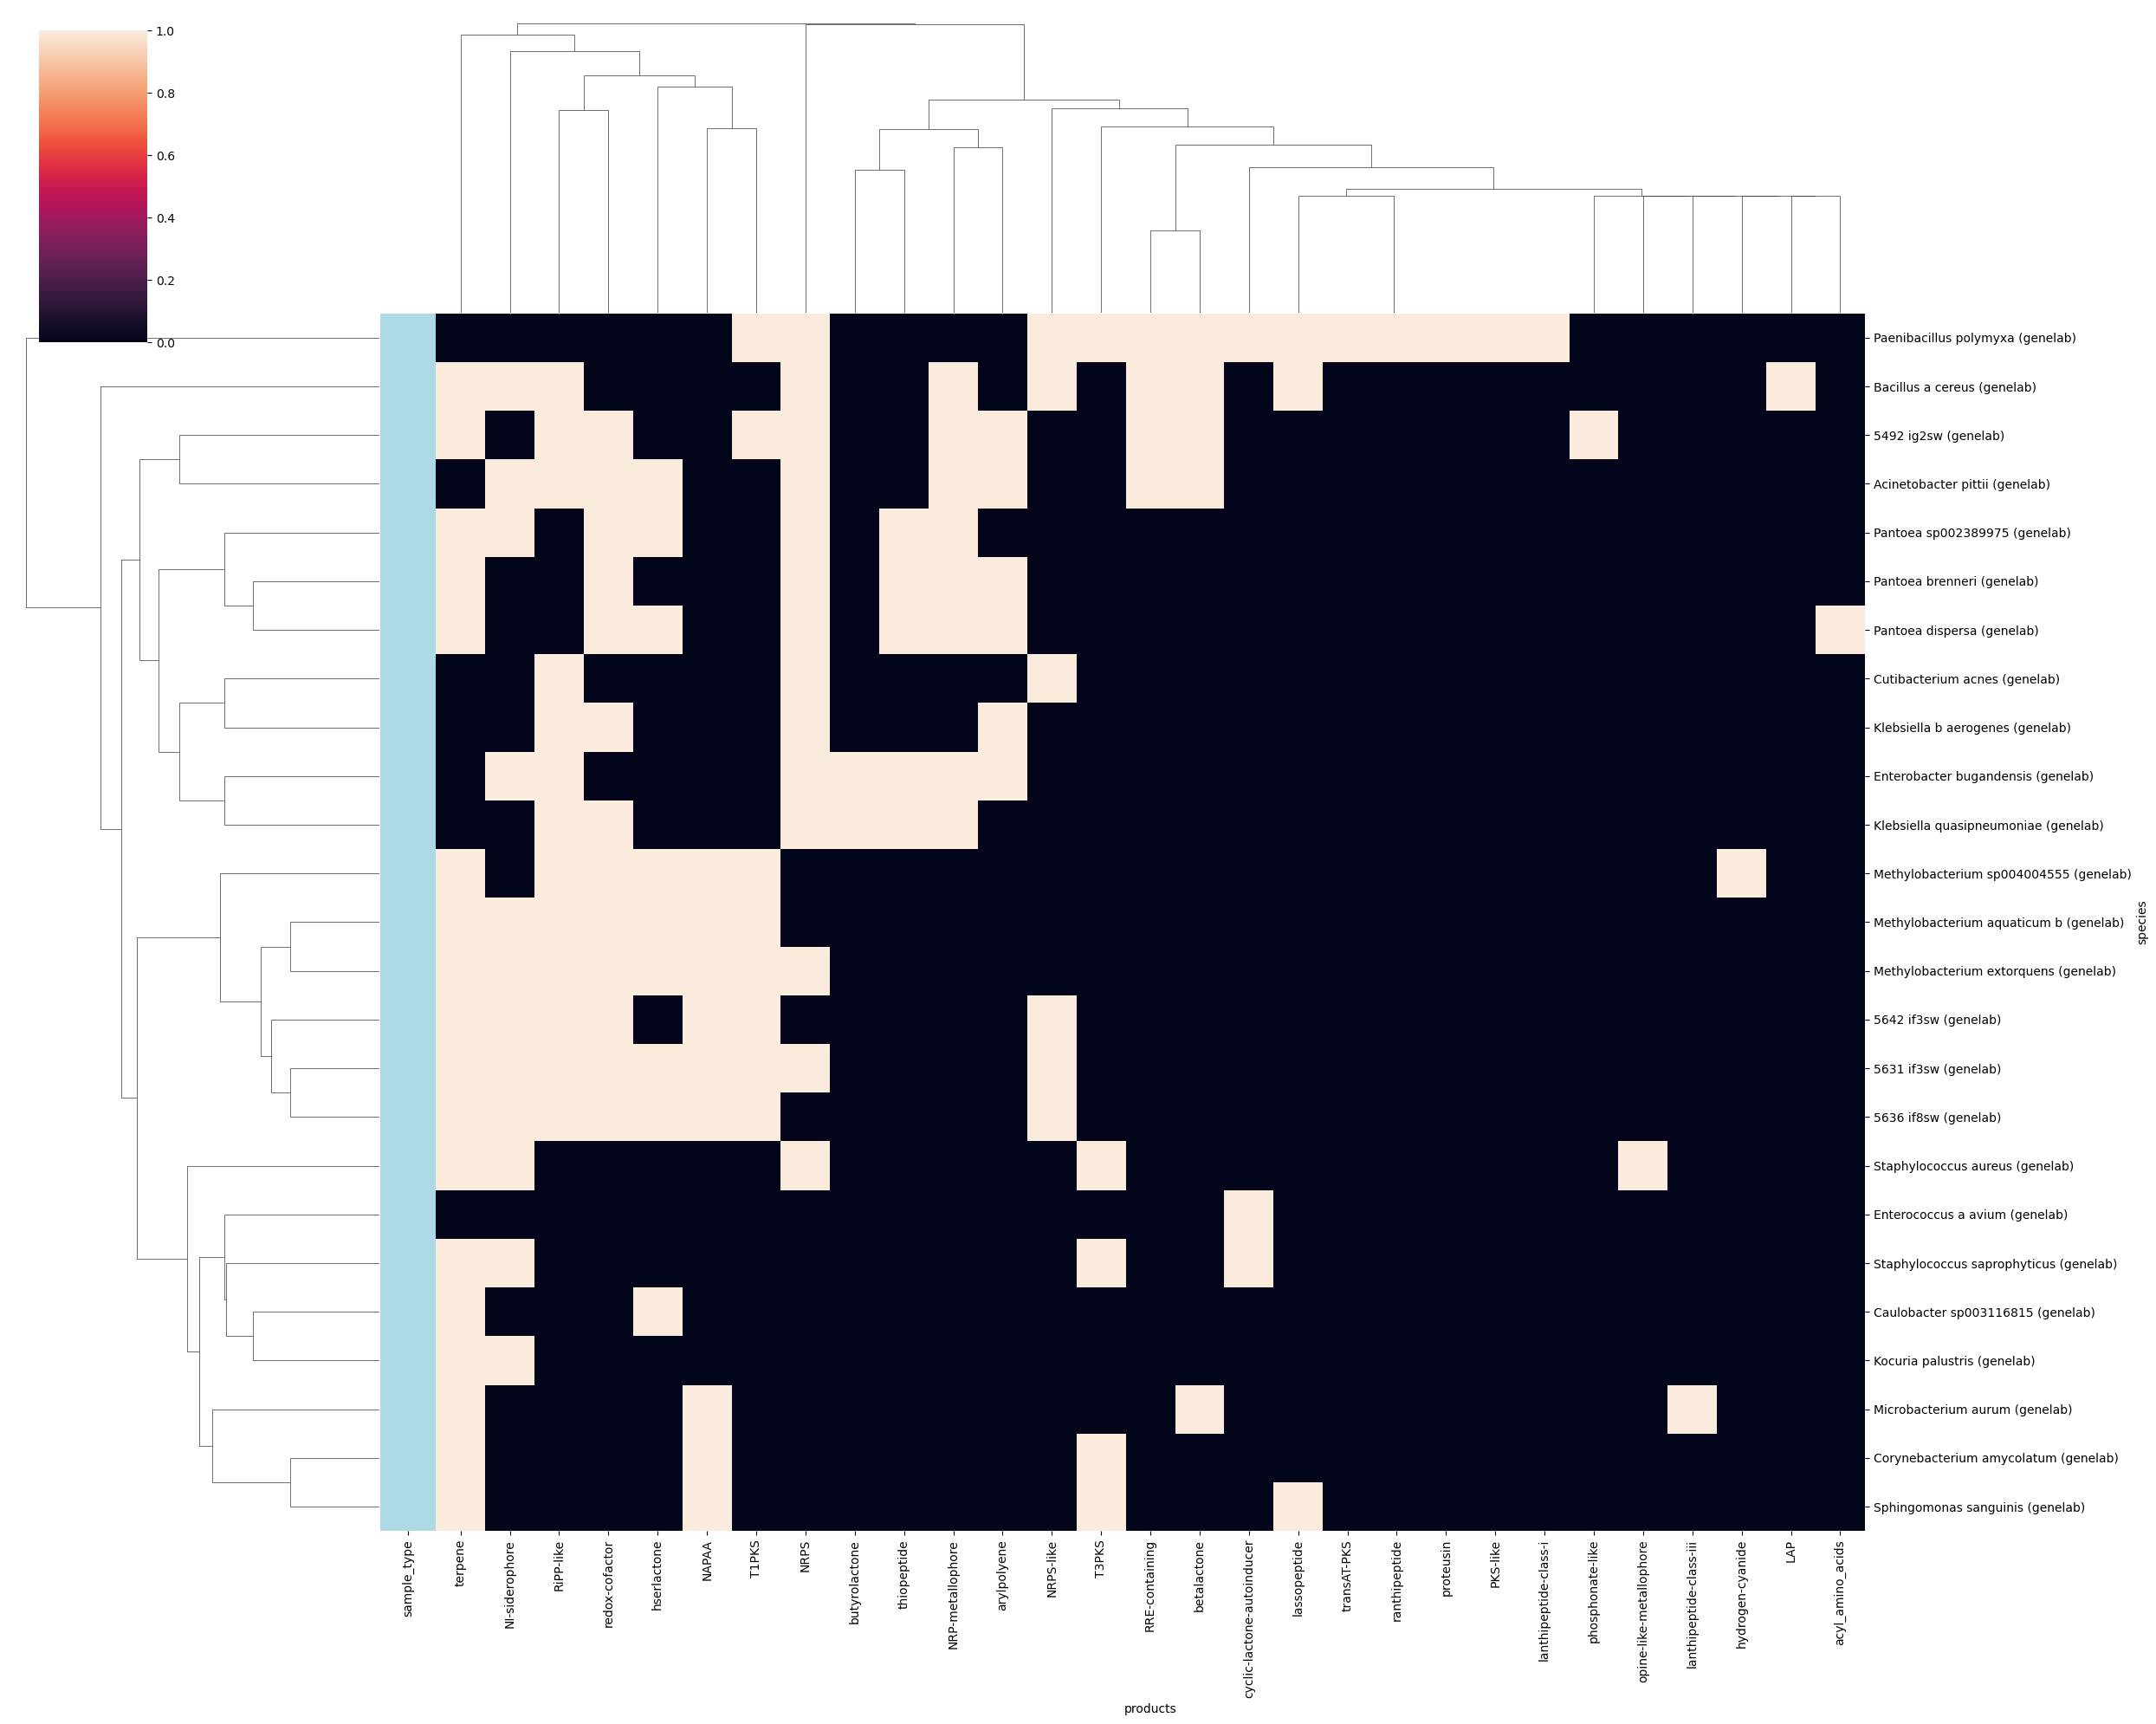

In [15]:
fig = sns.clustermap(
    data=species_df.astype(bool).astype(int),
    row_colors=sample_colors,
    figsize=(25, 20)
)
fig.savefig(
    fname="../figures/antismash-heatmap-binary-species.svg",
    dpi=500
)

## Genes

In [85]:
heat_df_genes = get_heat_df(df=results_df_genes, target_col="hit_id")
heat_df_genes, row_colors_genes = get_annotations(heat_df_genes)
heat_df_genes.head()

hit_id,SMCOG1000:ABC transporter ATP-binding protein,SMCOG1001:short-chain dehydrogenase/reductase SDR,SMCOG1002:AMP-dependent synthetase and ligase,SMCOG1003:sensor histidine kinase,SMCOG1004:thioesterase,"SMCOG1005:Drug resistance transporter, EmrB/QacA",SMCOG1006:acyl-CoA dehydrogenase,SMCOG1008:response regulator,SMCOG1009:mbtH-like protein,SMCOG1010:NAD-dependent epimerase/dehydratase,...,SMCOG1293:aldehyde oxidase and xanthine dehydrogenase,SMCOG1294:Nitrilase/cyanide hydratase and apolipoprotein,SMCOG1295:Sel1 domain protein repeat-containing protein,"SMCOG1296:tellurium resistance protein, TerD","SMCOG1297:Pullulanase, type I",SMCOG1299:chaperonin GroEL,SMCOG1300:hypothetical protein,sample_type,control,treatment
sample_name,,,,,,,,,,,,,,,,,,,,,
GLDS-69_GMetagenomics_5492_IG2SW-M_F1_L2_NORM_GC,4.0,6.0,13.0,3.0,3.0,0.0,1.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
GLDS-69_GMetagenomics_5501_IG2SW-P-M_F1_L2_PMA_GC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
GLDS-69_GMetagenomics_5630_IF2SW-M_F1_L2_NORM_FLT,6.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
GLDS-69_GMetagenomics_5631_IF3SW-P-M_F1_L3_PMA_FLT,6.0,3.0,9.0,9.0,0.0,0.0,0.0,12.0,0.0,4.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,1
GLDS-69_GMetagenomics_5633_IF5SW-M_F1_L5_NORM_FLT,7.0,3.0,5.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


In [86]:
col_colors_genes = results_df_genes[["products", "hit_id"]].copy()

# Many genes can be in different products, avoid duplicates
col_colors_genes["hit_id"] = \
    col_colors_genes["products"] + "_" + col_colors_genes["hit_id"]

col_colors_genes = col_colors_genes\
    .drop_duplicates("hit_id")\
    .dropna(subset="hit_id")\
    .set_index("hit_id")

color_mapping_prod_hits = dict(
    zip(
        col_colors_genes["products"].unique(),
        sns.color_palette("Set2", col_colors_genes["products"].nunique())
    )
)
col_colors_genes["products"] = col_colors_genes["products"]\
    .map(color_mapping_prod_hits)

# Add products to hit IDs to match with the color mapping
heat_df_genes.columns = heat_df_genes.columns.map({
    final_name.split("_")[-1]: final_name
    for final_name in col_colors_genes.index
})

In [87]:
# Generate legend
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

products_legend = []
for key in color_mapping_prod_hits:
        data_key = mpatches.Patch(
            color=color_mapping_prod_hits[key],
            label=key
        )
        products_legend.append(data_key)


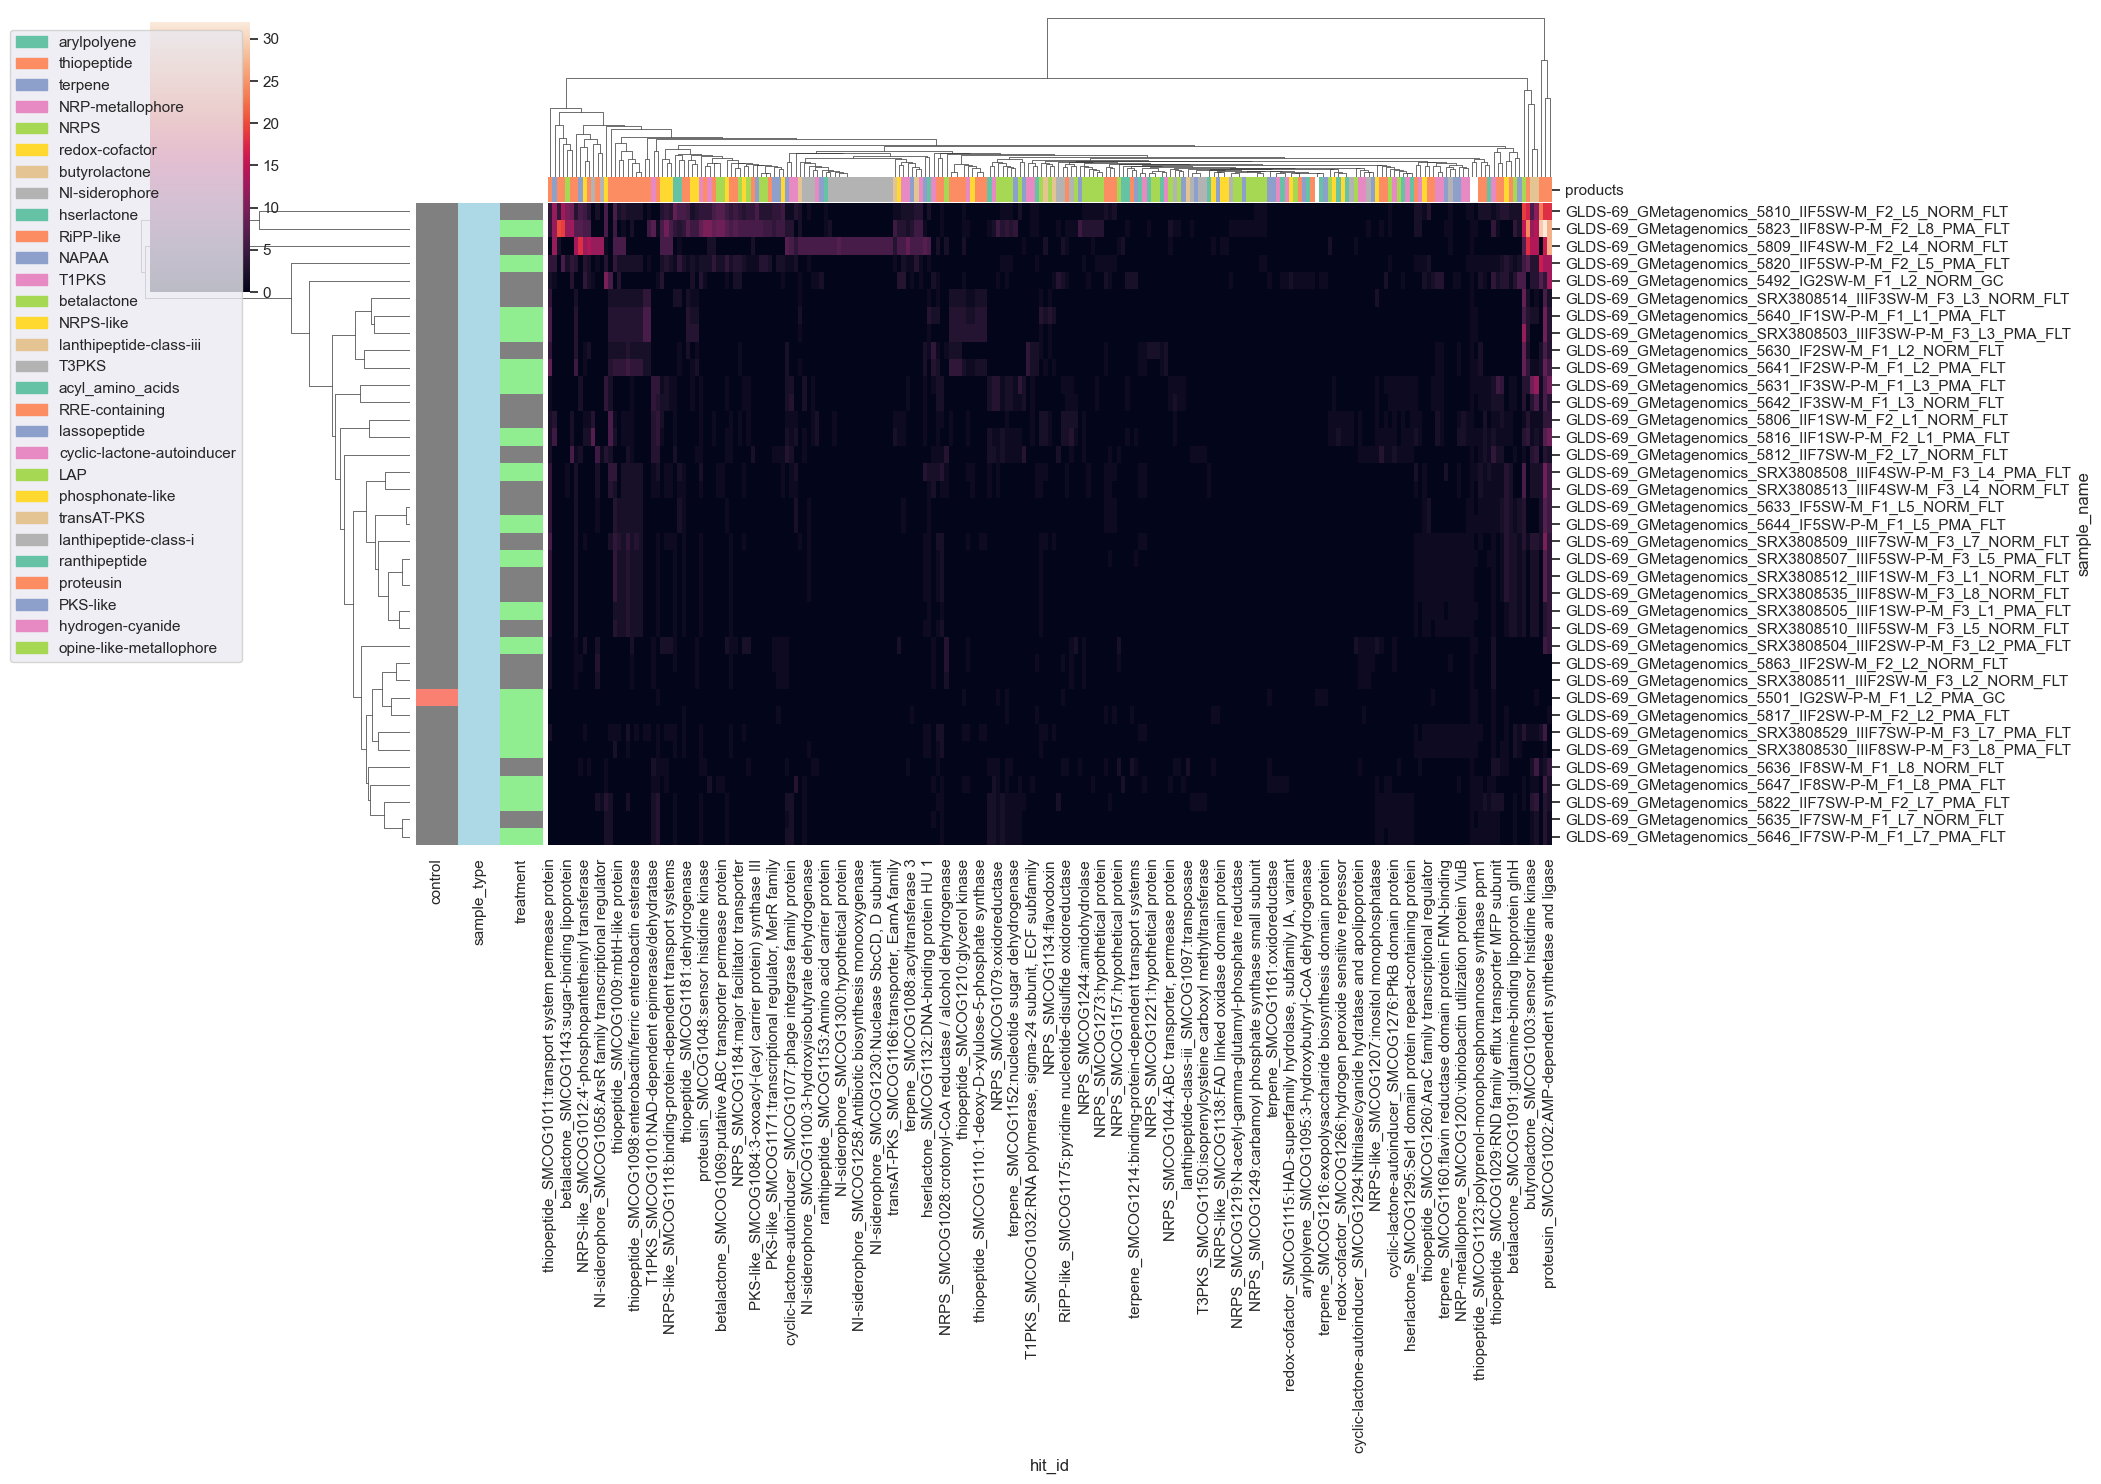

In [88]:
fig = sns.clustermap(
    data=heat_df_genes,
    row_colors=row_colors_genes,
    col_colors=col_colors_genes,
    figsize=(20, 15)
)
plt.legend(handles=products_legend)
fig.savefig(
    fname="../figures/antismash-heatmap-genes-absolute.svg",
    dpi=500
)